In [24]:
%matplotlib inline
from refer import REFER
import numpy as np
import sys
import os.path as osp
import json
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [36]:
data_root = './data'  # contains refclef, refcoco, refcoco+, refcocog and images
dataset = 'refcoco'
splitBy = 'unc'
refer = REFER(data_root, dataset, splitBy)

creating index...
index created.
DONE (t=%.2fs)


# 1. Evaluate Refering Expressions by Language Metrics

In [37]:
sys.path.insert(0, './evaluation')
from refEvaluation import RefEvaluation

In [38]:
# Here's our example expression file
sample_expr_file = json.load(open('test/sample_expressions_testA.json', 'r+'))
sample_exprs = sample_expr_file['predictions']
print(sample_exprs[0])

{'sent': 'man in black', 'ref_id': 47}


In [39]:
refEval = RefEvaluation(refer, sample_exprs)
refEval.evaluate()

tokenization...


TypeError: a bytes-like object is required, not 'str'

# 2. Evaluate Referring Expressions by Duplicate Rate

In [40]:
# evalue how many images contain duplicate expressions
pred_refToSent = {int(it['ref_id']): it['sent'] for it in sample_exprs}
pred_imgToSents = {}
for ref_id, pred_sent in pred_refToSent.items():
    image_id = refer.Refs[ref_id]['image_id']
    pred_imgToSents[image_id] = pred_imgToSents.get(image_id, []) + [pred_sent]
# count duplicate
duplicate = 0
for image_id, sents in pred_imgToSents.items():
    if len(set(sents)) < len(sents):
        duplicate += 1
ratio = duplicate*100.0 / len(pred_imgToSents)
print('%s/%s (%.2f%%) images have duplicate predicted sentences.'.format((duplicate, len(pred_imgToSents), ratio)))

%s/%s (%.2f%%) images have duplicate predicted sentences.


# 3.Evaluate Referring Comprehension

In [41]:
# IoU function
def computeIoU(box1, box2):
    # each box is of [x1, y1, w, h]
    inter_x1 = max(box1[0], box2[0])
    inter_y1 = max(box1[1], box2[1])
    inter_x2 = min(box1[0]+box1[2]-1, box2[0]+box2[2]-1)
    inter_y2 = min(box1[1]+box1[3]-1, box2[1]+box2[3]-1)

    if inter_x1 < inter_x2 and inter_y1 < inter_y2:
        inter = (inter_x2-inter_x1+1)*(inter_y2-inter_y1+1)
    else:
        inter = 0
    union = box1[2]*box1[3] + box2[2]*box2[3] - inter
    return float(inter)/union

In [42]:
# randomly sample one ref
ref_ids = refer.getRefIds()
ref_id = ref_ids[np.random.randint(0, len(ref_ids))]
ref = refer.Refs[ref_id]

# let's fake one bounding box by randomly picking one instance inside this image
image_id = ref['image_id']
anns = refer.imgToAnns[image_id]
ann = anns[np.random.randint(0, len(anns))]

%s. %s
%s. %s
%s. %s


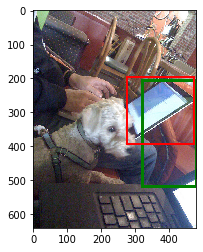

In [43]:
# draw box of the ref using 'green'
plt.figure()
refer.showRef(ref, seg_box='box')
# draw box of the ann using 'red'
ax = plt.gca()
bbox = ann['bbox']
box_plot = Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], fill=False, edgecolor='red', linewidth=2)
ax.add_patch(box_plot)
plt.show()

In [44]:
# Is the ann actually our ref?
# i.e., IoU >= 0.5?
ref_box = refer.refToAnn[ref_id]['bbox']
ann_box = ann['bbox']
IoU = computeIoU(ref_box, ann_box)
if IoU >= 0.5:
    print('IoU=[%.2f], correct comprehension!'.format(IoU))
else:
    print('IoU=[%.2f], wrong comprehension!'.format(IoU))

IoU=[%.2f], wrong comprehension!
